In [1]:
import geojson as gj
import matplotlib.pyplot as plt
import json
import numpy as np
import math
from geopy import distance
from os import system as sys

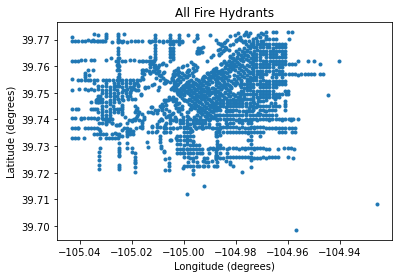

In [2]:
longHydrant = []
latHydrant = []

f = open("originalFiles/firehydrants.geojson")
data = gj.load(f)['features']
n = len(data)
for k in range(n):
    tmp = data[k]['geometry']['coordinates']
    longHydrant.append(data[k]['geometry']['coordinates'][0])
    latHydrant.append(data[k]['geometry']['coordinates'][1])
data = []
plt.figure()
plt.title("All Fire Hydrants")
plt.plot(longHydrant,latHydrant,'.')
plt.xlabel("Longitude (degrees)")
plt.ylabel("Latitude (degrees)")
plt.savefig("figures/AllHydrants.png")
f.close()

In [3]:
g = open("originalFiles/houses.json")
data = json.load(g)['elements']
g.close()

In [4]:
longHouse = []
latHouse = []
lowerLat = min(latHydrant)
lowerLong = min(longHydrant)
higherLat = max(latHydrant)
higherLong = max(longHydrant)
for k in range(len(data)):
    tmp = data[k]
    # Grab only the buildings and then only consider ones that are 'close' to the 
    # existing data for fire hydrants
    if ((tmp['type'] == 'node') and (tmp['lat'] <= higherLat + 0.01) and (tmp['lon'] >= lowerLong - 0.01) and (tmp['lon'] <= higherLong + 0.01) and (tmp['lat'] >= lowerLat -0.01)):
        latHouse.append(data[k]['lat'])
        longHouse.append(data[k]['lon'])
data = []

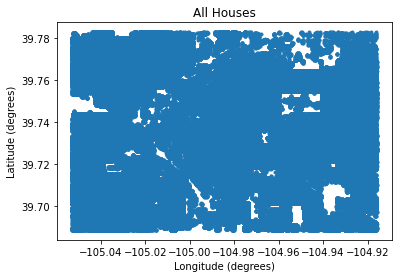

In [5]:
plt.figure()
plt.plot(longHouse,latHouse, '.')
plt.title("All Houses")
plt.xlabel("Longitude (degrees)")
plt.ylabel("Latitude (degrees)")
plt.savefig("figures/AllHouses.png")

Note: This is A LOT of data, about 646k buildings. This is a bit much for what we need, so we
run the cleaning.c program, which removes any building that does not abide by the denver fire code plus some offset.

Since a building must be 600 ft from a fire hydrant at maximum, so we remove any building from consideration that our data set says is 750 feet or more.

The extra 150 feet is to allow for potential errors in our computations

Looks a lot more reasonable! And more like the fire hydrant data

Although there is still about 330000 buildings we are considering

However, this is still way too large. When running the LP, it crashes after running for 2 days. So this is still not feasible
So we instead look at some select "neighborhoods"

There may be a better way of doing this, however, we look at google maps and select a few ranges of latitudes and longitudes, restrifct our data to this range, then run our LP

In [6]:
longVerts = [-104.96582, -104.95994, -104.96585, -104.95996]
latVerts = [39.77,39.77,39.76584, 39.76588]
longLow = min(longVerts)
longHigh = max(longVerts)
latLow = min(latVerts)
latHigh = max(latVerts)

In [7]:
g = open("originalFiles/houses.json")
data = []
data = json.load(g)['elements']

latHouse = []
longHouse = []

for k in range(len(data)):
    tmp = data[k]
    # Grab only the buildings and then only consider ones that are 'close' to the 
    # existing data for fire hydrants
    if ((tmp['type'] == 'node') and (tmp['lat'] <= latHigh + 0.001) and (tmp['lon'] >= longLow - 0.001) and (tmp['lon'] <= longHigh + 0.001) and (tmp['lat'] >= latLow -0.001)):
        latHouse.append(data[k]['lat'])
        longHouse.append(data[k]['lon'])
g.close()

In [8]:
f = open ("originalFiles/firehydrants.geojson")
data = []
data = gj.load(f)['features']
latHydrant = []
longHydrant = []
n = len(data)
for k in range(n):
    tmp = data[k]['geometry']['coordinates']
    if (tmp[1] >= latLow -.001 and tmp[1] <= latHigh+.001 and tmp[0] >= longLow-.0005 and tmp[0] <= longHigh+.001):
        longHydrant.append(tmp[0])
        latHydrant.append(tmp[1])
f.close()

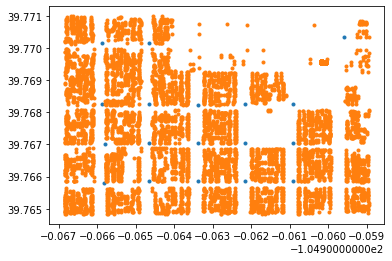

In [9]:
plt.figure()
plt.plot(longHydrant, latHydrant, '.')
plt.plot(longHouse, latHouse, '.')

In [10]:
# Now, we write this data out to then run ampl with
f = open("dataFiles/hydrantsSection1.txt", "w")
f.write("Latitude Longitude\n")
for k in range(len(longHydrant)):
    f.write("{} {}\n".format(latHydrant[k], longHydrant[k]))
f.close()

In [11]:
# Now, we write this data out to then run ampl with
f = open("dataFiles/housesSection1.txt", "w")
f.write("Latitude Longitude\n")
for k in range(len(longHouse)):
    f.write("{} {}\n".format(latHouse[k], longHouse[k]))
f.close()

In [12]:
sys("./makeDistances")
sys("./runClustering.sh")

Processing house 0
Processing house 1000
Processing house 2000
Processing house 3000
Processing house 4000
Processing house 5000
Processing house 6000
Processing house 7000
Time to execute: 0 seconds


0

In [13]:
f = open("out.txt")
f.readline()
f.readline()
hydrantIndex = -1

#This is a list of lists.
# The index in the parent list determines the hydrant we have
# The index in the child lists determine the index of the house associated with the given hydrant
housesPerHydrant = [];
for k in range(len(longHydrant)):
    housesPerHydrant.append([])

while True:
    line = f.readline()
    if not line:
        break
    if line[0] == 'c':
        hydrantIndex += 1
        #print(hydrantIndex)
        continue
    if line[0] == ';' or len(line) < 5:
        continue
    #print(hydrantIndex)
    lineParts = line.split()
    for k in range(len(lineParts)):
        if k % 2 == 1:
            continue
        houseIndex = int(lineParts[k])
        #print(houseIndex)
        if lineParts[k+1] == '1':
            housesPerHydrant[hydrantIndex].append(houseIndex - 1)
f.close()

In [14]:
for k in range(len(longHydrant)):
#for k in range(1):
    houseList = housesPerHydrant[k]
    longPlot = []
    latPlot = []
    for i in range(len(houseList)):
        longPlot.append(longHouse[houseList[i]])
        latPlot.append(latHouse[houseList[i]])
    plt.figure()
    plt.plot(longPlot,latPlot, 'r*')
    plt.plot(longHydrant,latHydrant, 'b.')
    plt.plot(longHydrant[k], latHydrant[k], 'go')
    plt.savefig("figures/hydrantClusterSection1_%02d.png" % k)
    plt.close()

In [15]:
longVerts = [-104.97798, -104.97363, -104.97803, -104.97347]
latVerts = [39.75446, 39.75443, 39.74964, 39.74956]
longLow = min(longVerts)
longHigh = max(longVerts)
latLow = min(latVerts)
latHigh = max(latVerts)

In [16]:
g = open("originalFiles/houses.json")
data = []
data = json.load(g)['elements']

latHouse = []
longHouse = []

for k in range(len(data)):
    tmp = data[k]
    # Grab only the buildings and then only consider ones that are 'close' to the 
    # existing data for fire hydrants
    if ((tmp['type'] == 'node') and (tmp['lat'] <= latHigh + 0.001) and (tmp['lon'] >= longLow - .0005) and (tmp['lon'] <= longHigh + 0.001) and (tmp['lat'] >= latLow -0.001)):
        latHouse.append(data[k]['lat'])
        longHouse.append(data[k]['lon'])
g.close()

In [17]:
f = open ("originalFiles/firehydrants.geojson")
data = []
data = gj.load(f)['features']
latHydrant = []
longHydrant = []
n = len(data)
for k in range(n):
    tmp = data[k]['geometry']['coordinates']
    if (tmp[1] >= latLow - .001 and tmp[1] <= latHigh + .001 and tmp[0] >= longLow  and tmp[0] <= longHigh + .001):
        longHydrant.append(tmp[0])
        latHydrant.append(tmp[1])
f.close()

In [18]:
print(len(longHydrant))

27


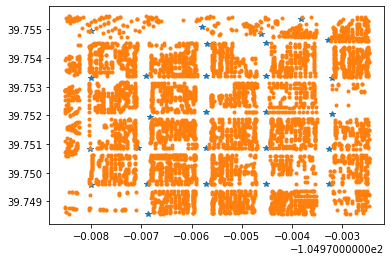

In [19]:
plt.figure()
plt.plot(longHydrant, latHydrant, '*')
plt.plot(longHouse, latHouse, '.')

In [20]:
# Now, we write this data out to then run ampl with
f = open("dataFiles/hydrantsSection2.txt", "w")
f.write("{}\n".format(len(longHydrant)))
f.write("Latitude Longitude\n")
for k in range(len(longHydrant)):
    f.write("{} {}\n".format(latHydrant[k], longHydrant[k]))
f.close()

In [21]:
# Now, we write this data out to then run ampl with
f = open("dataFiles/housesSection2.txt", "w")
f.write("{}\n".format(len(longHouse)))
f.write("Latitude Longitude\n")
for k in range(len(longHouse)):
    f.write("{} {}\n".format(latHouse[k], longHouse[k]))
f.close()

In [22]:
sys("./makeDistances dataFiles/housesSection2.txt dataFiles/hydrantsSection2.txt dataFiles/Clustering.dat")
sys("./runClustering.sh")

Processing house 0
Processing house 1000
Processing house 2000
Processing house 3000
Processing house 4000
Processing house 5000
Processing house 6000
Time to execute: 0 seconds


0

In [23]:
f = open("out.txt")
f.readline()
f.readline()
hydrantIndex = -1

#This is a list of lists.
# The index in the parent list determines the hydrant we have
# The index in the child lists determine the index of the house associated with the given hydrant
housesPerHydrant = [];
for k in range(len(longHydrant)):
    housesPerHydrant.append([])

while True:
    line = f.readline()
    if not line:
        break
    if line[0] == 'c':
        hydrantIndex += 1
        #print(hydrantIndex)
        continue
    if line[0] == ';' or len(line) < 5:
        continue
    #print(hydrantIndex)
    lineParts = line.split()
    for k in range(len(lineParts)):
        if k % 2 == 1:
            continue
        houseIndex = int(lineParts[k])
        #print(houseIndex)
        if lineParts[k+1] == '1':
            housesPerHydrant[hydrantIndex].append(houseIndex - 1)
f.close()

In [24]:
for k in range(len(longHydrant)):
#for k in range(1):
    houseList = housesPerHydrant[k]
    longPlot = []
    latPlot = []
    for i in range(len(houseList)):
        longPlot.append(longHouse[houseList[i]])
        latPlot.append(latHouse[houseList[i]])
    plt.figure()
    plt.plot(longHouse, latHouse, '.')
    plt.plot(longPlot,latPlot, 'r*')
    plt.plot(longHydrant,latHydrant, 'm.')
    plt.plot(longHydrant[k], latHydrant[k], 'go')
    plt.title("Houses Assigned to Hydrant {}".format(k))
    plt.xlabel("Longitude (degrees)")
    plt.ylabel("Latitude (degrees)")
    plt.savefig("figures/hydrantClusterSection2_%02d.png" % k)
    plt.close()

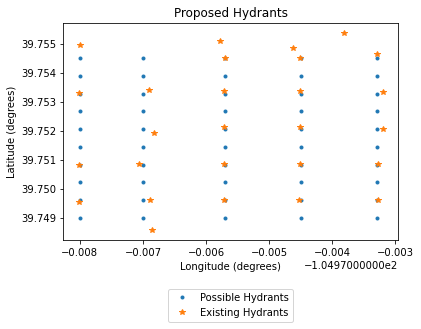

In [25]:
# Construct the new hydrants
hydrantsLat = []
hydrantsLong = []
a = [-104.978, -104.977,-104.9757,-104.9745,-104.9733]
b = np.linspace(39.749, 39.7545,num=10)
for lat in b:
    for long in a:
        hydrantsLat.append(lat)
        hydrantsLong.append(long)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(hydrantsLong, hydrantsLat, '.', label="Possible Hydrants")
ax.plot(longHydrant, latHydrant, '*', label = "Existing Hydrants")
ax.set_title("Proposed Hydrants")
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Latitude (degrees)")
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.2))
plt.savefig("figures/proposedHydrants.png",bbox_extra_artists=(lgd,), bbox_inches='tight')

In [26]:
# Now, we write this data out to then run ampl with
f = open("dataFiles/hydrantsSection2Location.txt", "w")
f.write("{}\n".format(len(longHydrant)))
f.write("Latitude Longitude\n")
for k in range(len(longHydrant)):
    f.write("{} {}\n".format(latHydrant[k], longHydrant[k]))
for k in range(len(hydrantsLong)):
    f.write("{} {}\n".format(hydrantsLat[k], hydrantsLong[k]))
f.close()

In [27]:
# Now, we write this data out to then run ampl with
f = open("dataFiles/housesSection2Location.txt", "w")
f.write("{}\n".format(len(longHouse)))
f.write("Latitude Longitude\n")
for k in range(len(longHouse)):
    f.write("{} {}\n".format(latHouse[k], longHouse[k]))
f.close()

In [28]:
sys("./makeDistances dataFiles/housesSection2Location.txt dataFiles/hydrantsSection2Location.txt dataFiles/Location.dat")
sys("./runLocation.sh")

Processing house 0
Processing house 1000
Processing house 2000
Processing house 3000
Processing house 4000
Processing house 5000
Processing house 6000
Time to execute: 1 seconds


0

In [29]:
f = open("outLoc.txt")
f.readline()
f.readline()
f.readline()

hydrantIndex = -1

for long in hydrantsLong:
    longHydrant.append(long)
for lat in hydrantsLat:
    latHydrant.append(lat)

#This is a list of lists.
# The index in the parent list determines the hydrant we have
# The index in the child lists determine the index of the house associated with the given hydrant
housesPerHydrant = [];
for k in range(len(longHydrant)):
    housesPerHydrant.append([])
madeHydrants = []
while True:
    line = f.readline()
    if not line:
        break
    if line[0] == 'c' or line[0] == 'm':
        hydrantIndex += 1
        #print(hydrantIndex)
        continue
    if line[0] == ';' or len(line) < 5:
        continue
    #print(hydrantIndex)
    lineParts = line.split()
    for k in range(len(lineParts)):
        if k % 2 == 1:
            continue
        houseIndex = int(lineParts[k])
        #print(houseIndex)
        if lineParts[k+1] == '1':
            housesPerHydrant[hydrantIndex].append(houseIndex - 1)
f.close()

In [30]:
longKept = []
latKept = []
for k in range(len(longHydrant)):
    if (len(housesPerHydrant[k]) != 0):
        longKept.append(longHydrant[k])
        latKept.append(latHydrant[k])
print(len(longKept))
for k in range(len(longHydrant)):
#for k in range(1):
    houseList = housesPerHydrant[k]
    longPlot = []
    latPlot = []
    for i in range(len(houseList)):
        longPlot.append(longHouse[houseList[i]])
        latPlot.append(latHouse[houseList[i]])
    plt.figure()
    plt.plot(longHouse, latHouse, '.')
    plt.plot(longPlot,latPlot, 'r*')
    plt.plot(longKept,latKept, 'm.')
    plt.plot(longHydrant[k], latHydrant[k], 'go')
    plt.title("Houses Assigned to Hydrant {}".format(k))
    plt.xlabel("Longitude (degrees)")
    plt.ylabel("Latitude (degrees)")
    plt.savefig("figures/hydrantLocationSection2_%03d.png" % k)
    plt.close()

28


## 